In [39]:
from matplotlib.colors import Normalize
import os
import json
import torch
import numpy as np

def calculate_attention_values(attention_matrix, input_tokens, output_tokens, image_token_start_idx, image_token_end_idx):
    # Calculate the average image tokens for each output token before normalizing
    average_attention_scores = []

    # calculate rationale's attention scores
    for i, output_token in enumerate(output_tokens):
        output_relevancy = attention_matrix[len(input_tokens) - 1 + i, :]
        image_tokens = output_relevancy[image_token_start_idx:image_token_end_idx]
        text_tokens = output_relevancy[image_token_end_idx + 1:len(input_tokens)-3]
    
        average_text_tokens = np.mean(text_tokens)
        average_image_tokens = np.mean(image_tokens)
        
        average_attention_scores.append({
            "id": i,
            "output_token": output_token,
            "average_text_tokens": average_text_tokens,
            "average_image_tokens": average_image_tokens,
            "average_image_to_text_ratio": average_image_tokens / average_text_tokens,
            "text_tokens": text_tokens,
            "image_tokens": image_tokens
        })

    return average_attention_scores 

def calculate_image_text_ratio(attention_scores, normalize=True):
    ratio_list = []
    for output_token in attention_scores:
        ratio_list.append(output_token["average_image_to_text_ratio"])

    ratio_list = np.array(ratio_list)
    
    return np.mean(ratio_list)

def process_data(file_names, base):
  processed_data = {key: {'items': []} for key in file_names}
  for key, file_name in file_names.items():
    with open(os.path.join(base, file_name, "results.json"), "r") as file:
      results = json.load(file)

    for i, result in enumerate(results[:100]):
      if result["predicted_answer"] == "":
          continue;
          
      average_attention_matrix = torch.load(os.path.join(base, file_name, "attention_weights", f"{i}.pt"), map_location=torch.device('cpu'))
      attention_file = os.path.join(base, file_name, "attention", f"{i}.json")
      with open(attention_file, "r") as file:
          attention_description = json.load(file)

      # filter tokens
      output_tokens = [token.replace('Ġ', '').replace('Ċ', '') for token in attention_description["output_tokens"]]
      input_tokens = [token.replace('Ġ', '').replace('Ċ', '') for token in attention_description["input_tokens"]]
      image_token_indices = [i for i, token in enumerate(input_tokens) if token.startswith("image_")]
      image_token_start_idx = image_token_indices[0]
      image_token_end_idx = image_token_indices[-1] + 1
      main_input_text_tokens = input_tokens[image_token_end_idx + 1:len(input_tokens)]

      attention_results = calculate_attention_values(average_attention_matrix, input_tokens, output_tokens, image_token_start_idx, image_token_end_idx)
      image_text_ratio = calculate_image_text_ratio(attention_results)

      # store in processed data structure
      item_data = {
          "idx": i,
          'attention_results': attention_results,
          'input_tokens': input_tokens,
          'output_tokens': output_tokens,
          'image_token_start_idx': image_token_start_idx,
          'image_token_end_idx': image_token_end_idx,
          'average_image_to_text_ratio': image_text_ratio,
          'main_input_text_tokens': main_input_text_tokens,
          'predicted_answer': result["predicted_answer"],
          'problem': {
              "problem_text": result["problem_text"],
              "choices": result["choices"],
              "answer": result["answer"],
              "image": result["image_id"] + ".png",
              "predicted_answer": result["predicted_answer"],
              "extracted_answer": result["extracted_answer"],
              "problem_type_graph": result["problem_type_graph"],
              "problem_type_goal": result["problem_type_goal"],
          }
      }
      processed_data[key]['items'].append(item_data)

    average_ratios = np.mean([item['average_image_to_text_ratio'] for item in processed_data[key]['items']])
    processed_data[key]['average_image_to_text_ratio'] = average_ratios

    correct_average_image_to_text_ratio = np.mean([
        item['average_image_to_text_ratio'] for item in processed_data[key]['items']
        if item['problem']['extracted_answer'] == item['problem']['answer']
    ])
    
    wrong_average_image_to_text_ratio = np.mean([
        item['average_image_to_text_ratio'] for item in processed_data[key]['items']
        if item['problem']['extracted_answer'] != item['problem']['answer']
    ])
    
    processed_data[key]['correct_average_image_to_text_ratio'] = correct_average_image_to_text_ratio
    processed_data[key]['wrong_average_image_to_text_ratio'] = wrong_average_image_to_text_ratio
    
    processed_data[key]['correct_count'] = sum(1 for item in processed_data[key]['items'] if item['problem']['extracted_answer'] == item['problem']['answer'])
    processed_data[key]['wrong_count'] = sum(1 for item in processed_data[key]['items'] if item['problem']['extracted_answer'] != item['problem']['answer'])
    
  return processed_data


In [41]:
import matplotlib.pyplot as plt

def plot_average_image_to_text_ratios(processed_data, activations, type="all"):
  keys = list(processed_data.keys())

  if type == "correct_wrong":
    correct_ratios = [processed_data[key]['correct_average_image_to_text_ratio'] for key in keys if activations[key]]
    wrong_ratios = [processed_data[key]['wrong_average_image_to_text_ratio'] for key in keys if activations[key]]

    # Print number of correct and wrong items
    correct_counts = [processed_data[key]['correct_count'] for key in keys if activations[key]]
    wrong_counts = [processed_data[key]['wrong_count'] for key in keys if activations[key]]
    for key, correct_count, wrong_count in zip(keys, correct_counts, wrong_counts):
        if activations[key]:
            print(f"Model: {key}, Correct: {correct_count}, Wrong: {wrong_count}")

    # Plotting the bar graph for both correct and wrong ratios
    x = [key for key in keys if activations[key]]
    x_indices = range(len(x))

    plt.figure(figsize=(10, 6))
    plt.bar(x_indices, correct_ratios, width=0.4, label='Correct', color='green', align='center')
    plt.bar(x_indices, wrong_ratios, width=0.4, label='Wrong', color='red', align='edge')
    plt.xlabel('Models')
    plt.ylabel('Average Image to Text Ratio')
    plt.title('Average Image to Text Ratio for Different File Names (Correct vs Wrong)')
    plt.xticks(ticks=x_indices, labels=x, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
  else:
    # Extract keys and their corresponding average_image_to_text_ratio values
    average_ratios = [processed_data[key]["average_image_to_text_ratio"] for key in keys if activations[key]]

    # Plotting the bar graph
    plt.figure(figsize=(10, 6))
    plt.bar([key for key in keys if activations[key]], average_ratios, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel(f'Average Image to Text Ratio ({type})')
    plt.title(f'Average Image to Text Ratio for Different File Names ({type})')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [34]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import Normalize


def visualize_word_map(idx, processed_data, activations):
  # normalize ratios! 
  ratios = []
  for key, data in processed_data.items():
    if activations[key] == 1:
      items = data['items'][idx]["attention_results"]
      ratios.append([item['average_image_to_text_ratio'] for item in items])

  ratios_flat = [ratio for sublist in ratios for ratio in sublist]
  vmin = min(ratios_flat)
  vmax = max(ratios_flat)
  norm = lambda x: (x - vmin) / (vmax - vmin) if vmax != vmin else 0.5
  normalized_ratios_flat = [norm(ratio) for ratio in ratios_flat]
  
  final_ratios = []
  index = 0
  for sublist in ratios:
    final_ratios.append(normalized_ratios_flat[index:index + len(sublist)])
    index += len(sublist)
  
  # plot the graph!
  main_idx = 0
  cmap = cm.Oranges
  for key, data in processed_data.items():
    if activations[key] == 1:
      print(key)
      fig, ax = plt.subplots(figsize=(3, 2))
      item = data['items'][idx]

      x_coord = 0
      y_coord = 0.5
      for i, (output_token, normalized_value) in enumerate(zip(item["output_tokens"], final_ratios[main_idx])):
        color = cmap(normalized_value)
        ax.text(x_coord, y_coord, output_token, ha='left', va='center', fontsize=30, 
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))
        x_coord += (len(output_token)/6)
        if (i + 1) % 20 == 0:
            x_coord = 0
            y_coord -= 0.5  # Shift down a little for every 5 tokens

      # Remove axes
      ax.axis('off')

      # Adjust layout
      plt.tight_layout()
      plt.show()
      main_idx += 1

In [40]:
base = "/piech/u/joetey/multimodal-reasoning/results/files/"

file_names = {
  "baseline_direct": "results_geometry_3k_baseline_direct_20240602_022225",
  "baseline_cot": "results_geometry_3k_baseline_cot_20240601_200750",
  "finetuned_cot": "results_geometry_3k_finetuned_20240601_201028",
  "finetuned_logic": "results_geometry_3k_finetuned_logic_20240601_222942",
  "finetuned_peano": "results_geometry_3k_finetuned_peano_20240601_213131",
  "finetuned_multiclass": "results_geometry_3k_finetuned_peano_20240601_213131"
}


processed_data = process_data(file_names, base)

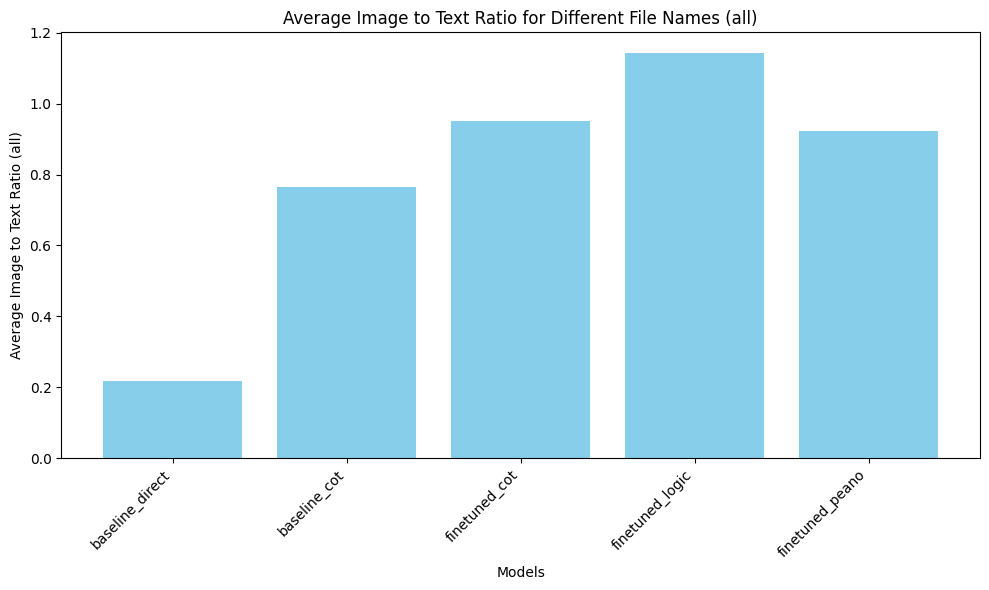

Model: baseline_direct, Correct: 16, Wrong: 46
Model: baseline_cot, Correct: 26, Wrong: 74
Model: finetuned_cot, Correct: 34, Wrong: 66
Model: finetuned_logic, Correct: 28, Wrong: 72
Model: finetuned_peano, Correct: 26, Wrong: 72


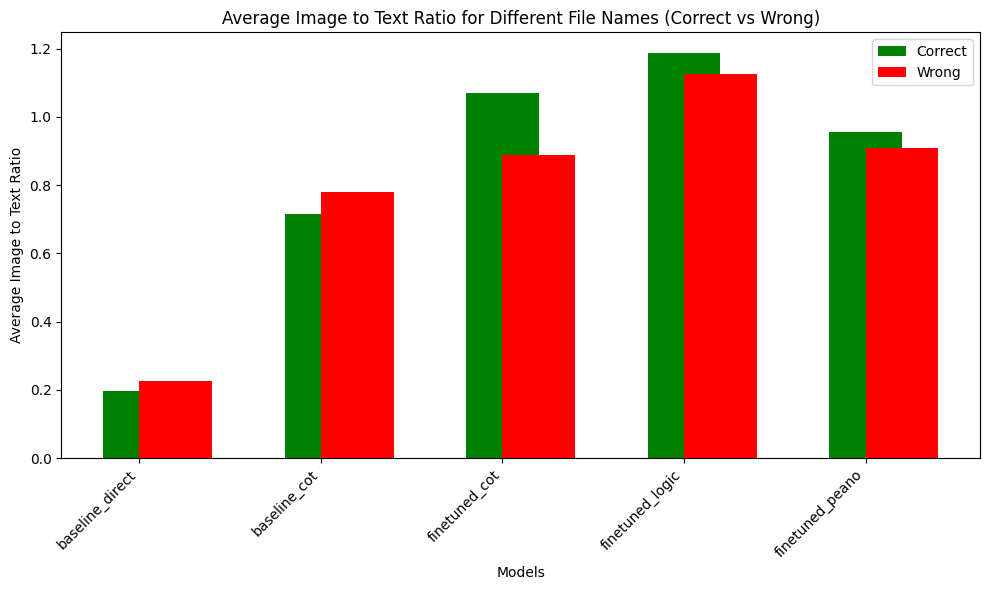

In [42]:
activations = {
  "baseline_direct": 1,
  "baseline_cot": 1,
  "finetuned_cot": 1,
  "finetuned_logic": 1,
  "finetuned_peano": 1,
  "finetuned_multiclass": 0,
}

plot_average_image_to_text_ratios(processed_data, activations, "all")
plot_average_image_to_text_ratios(processed_data, activations, "correct_wrong")

baseline_direct


/tmp/joetey/ipykernel_3736191/340293506.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


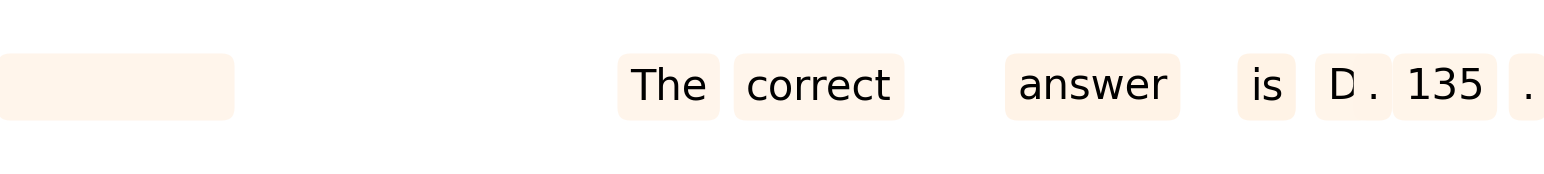

baseline_cot


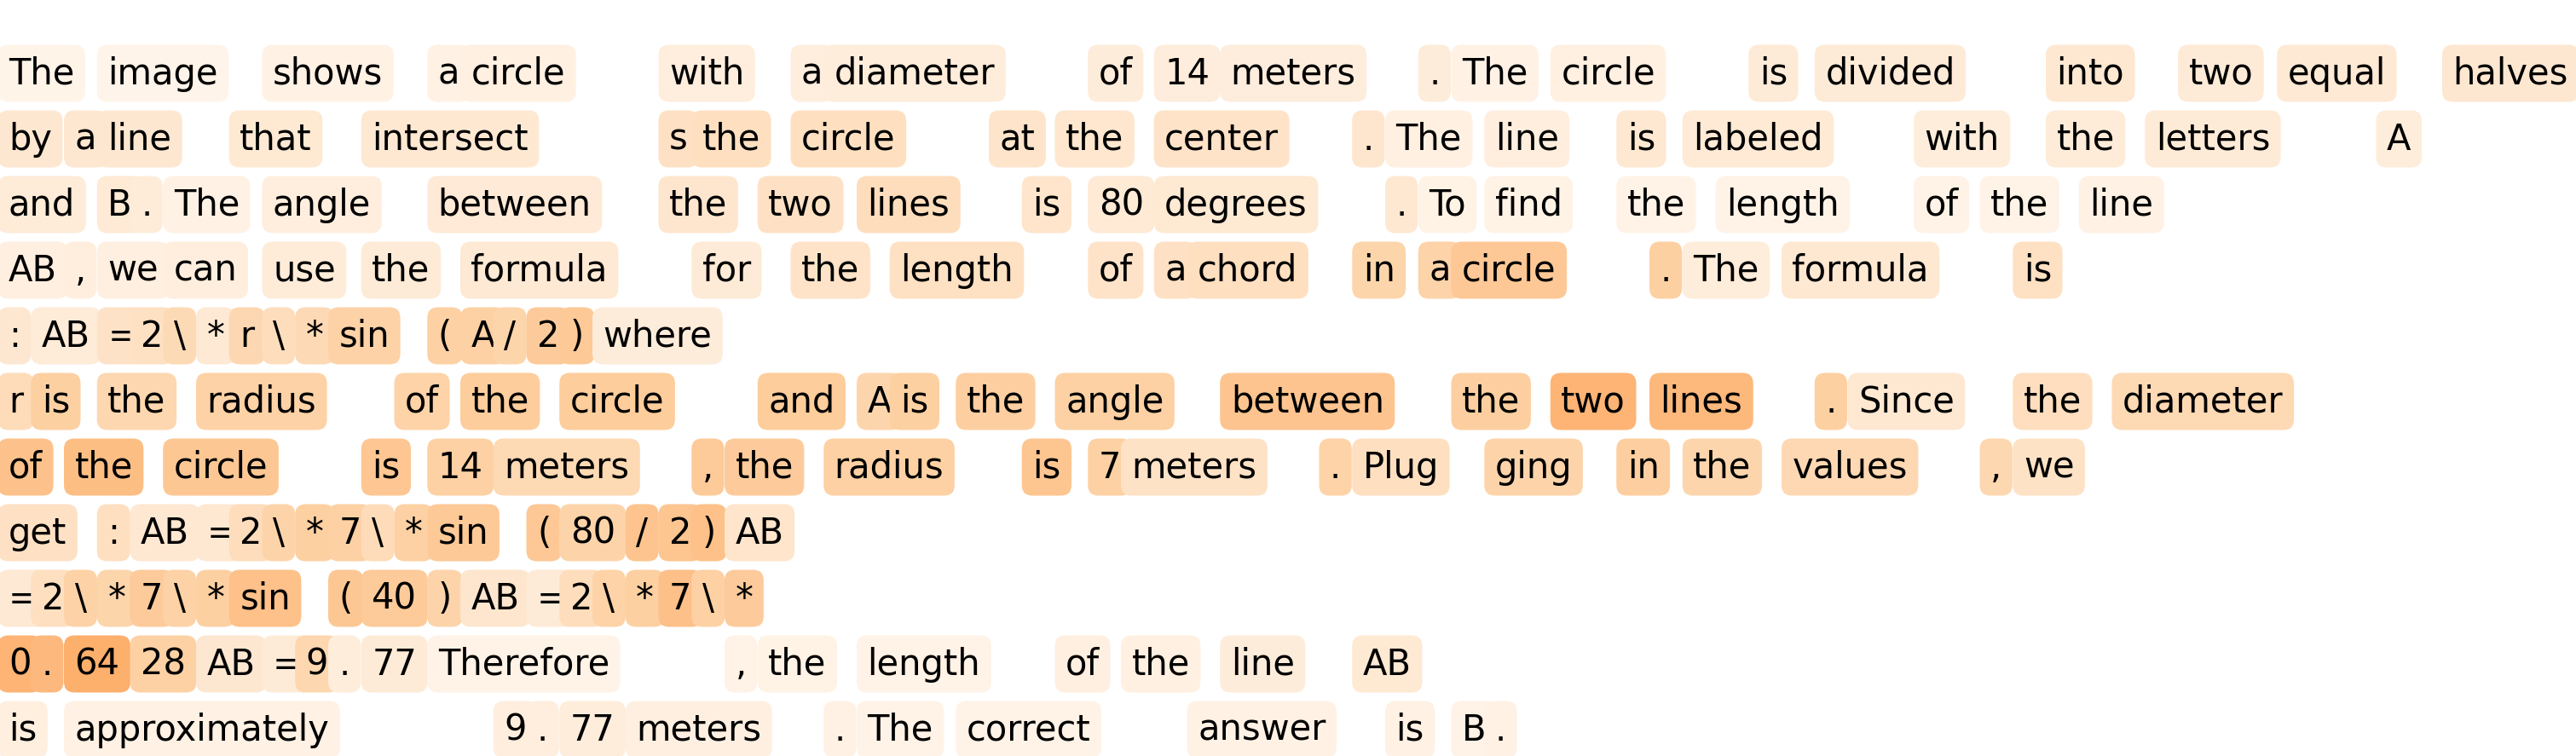

finetuned_cot


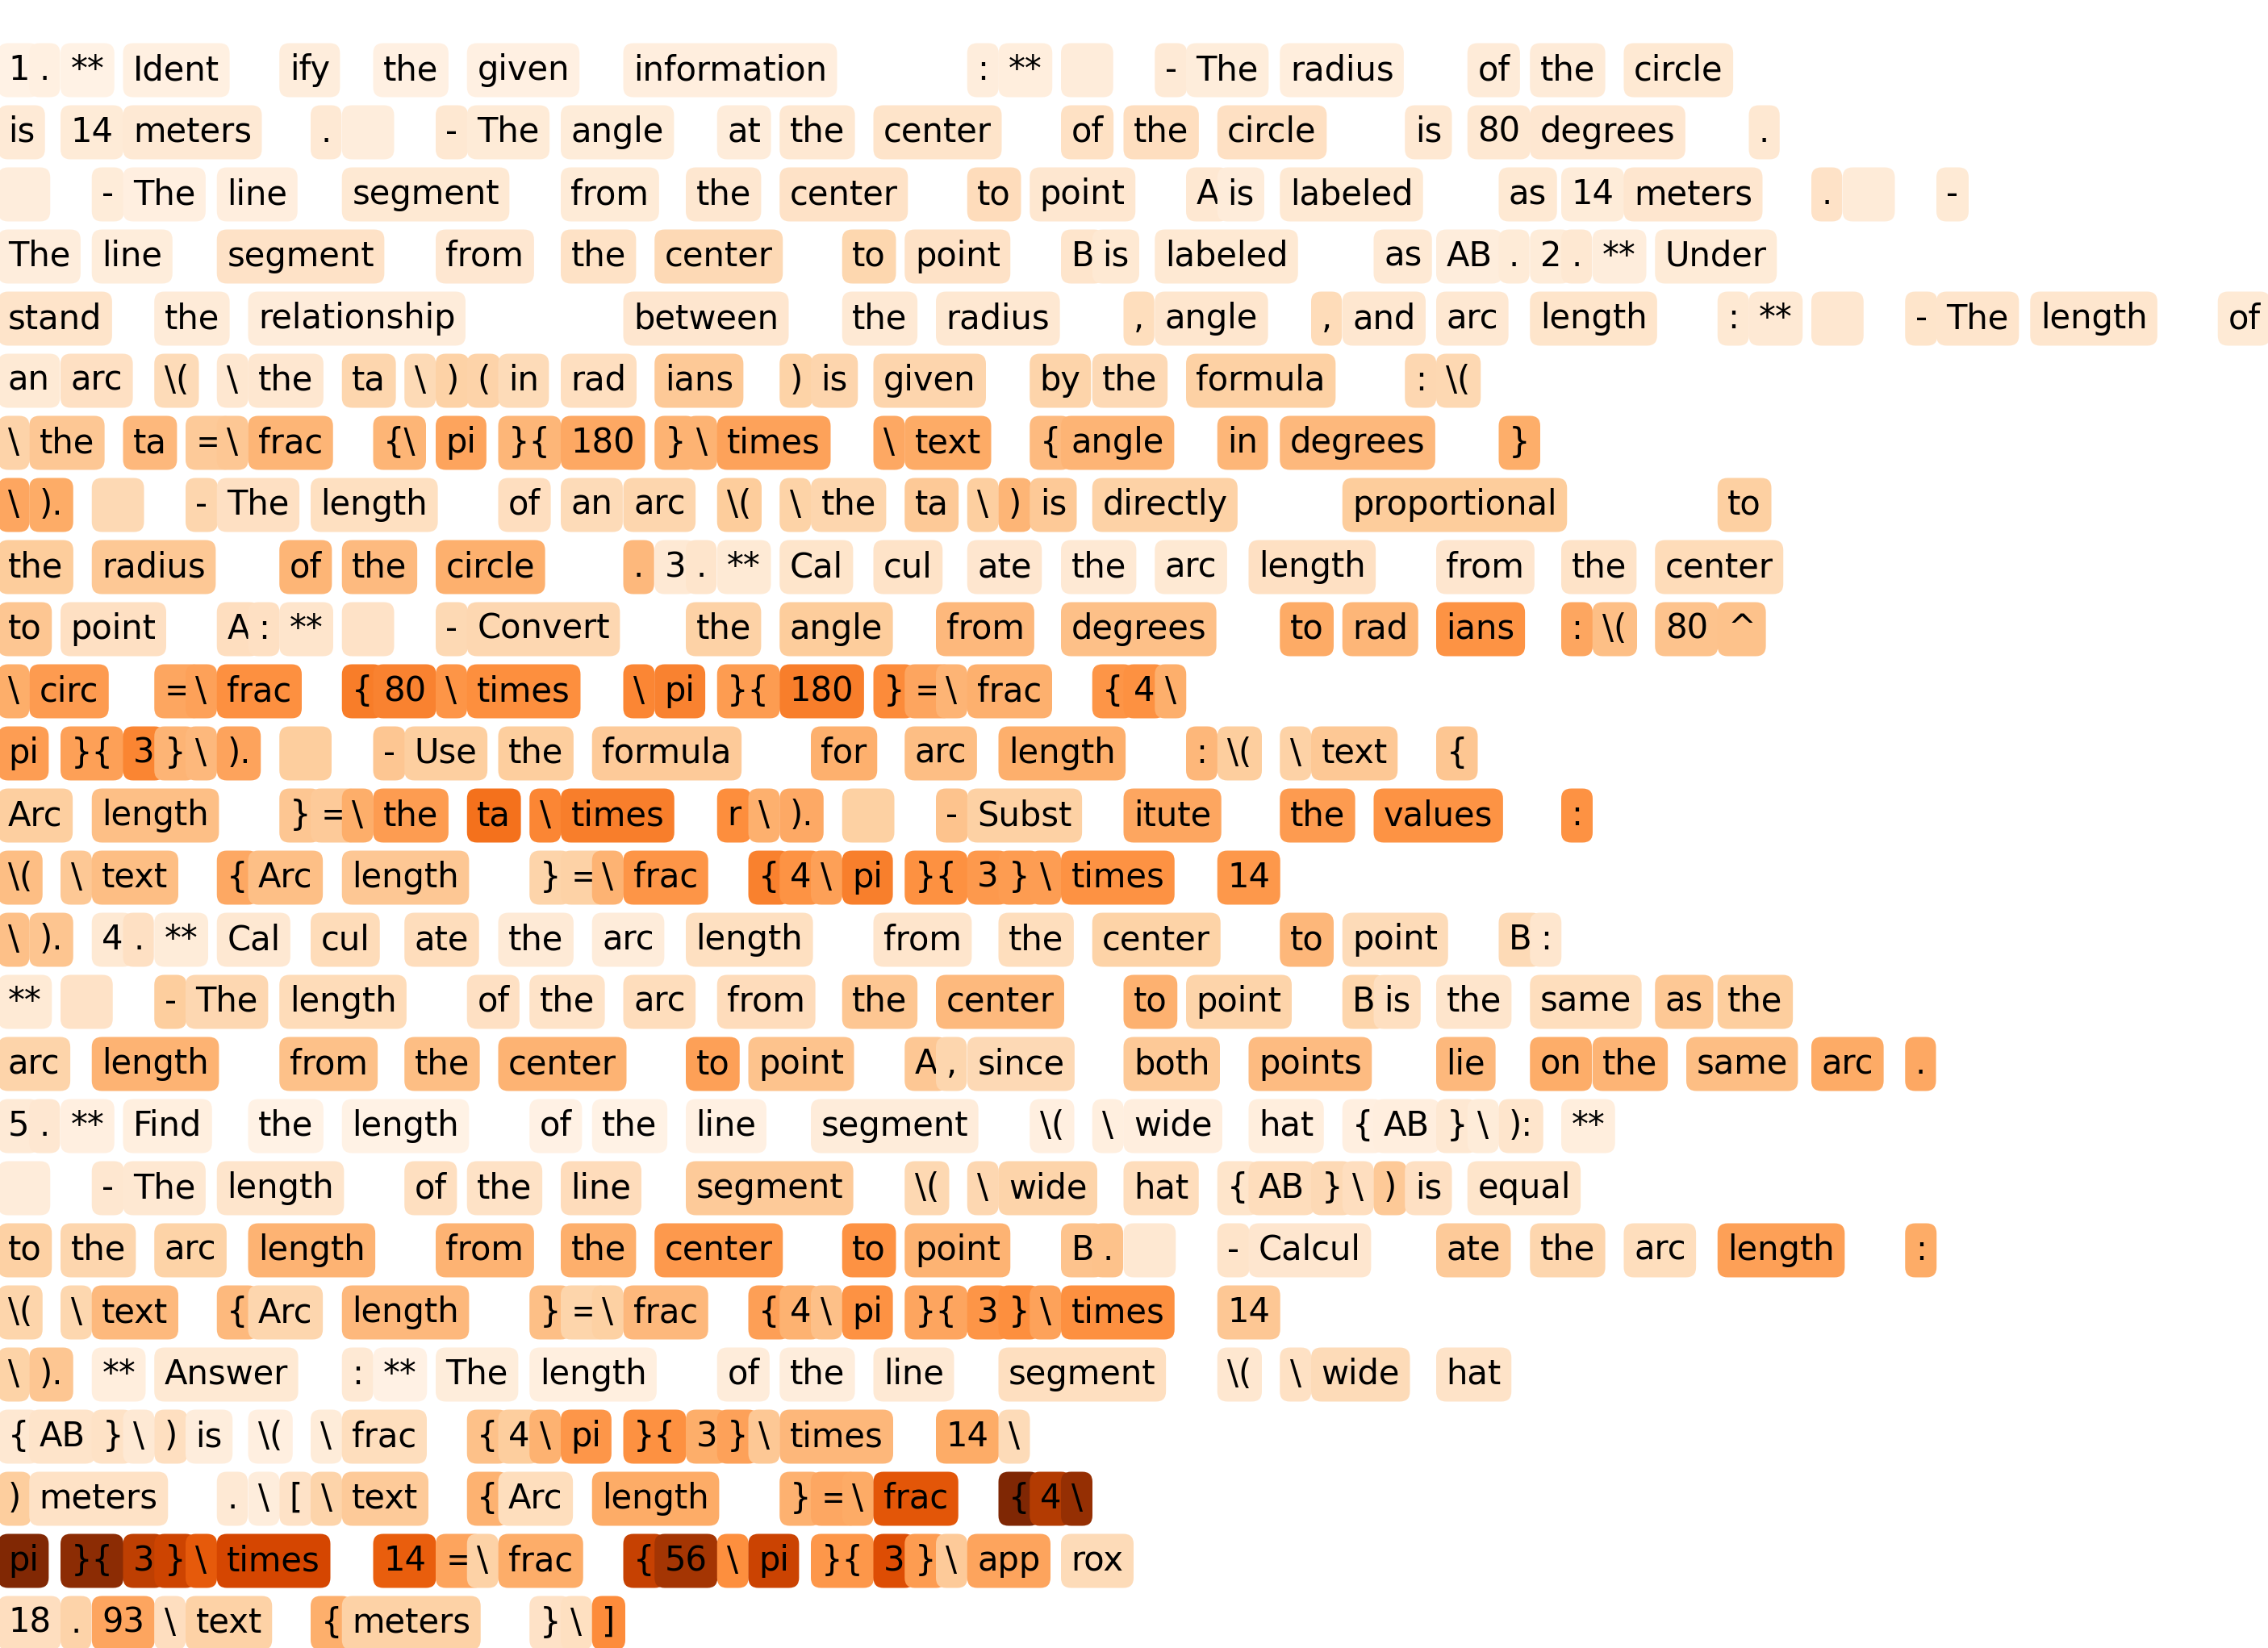

finetuned_logic


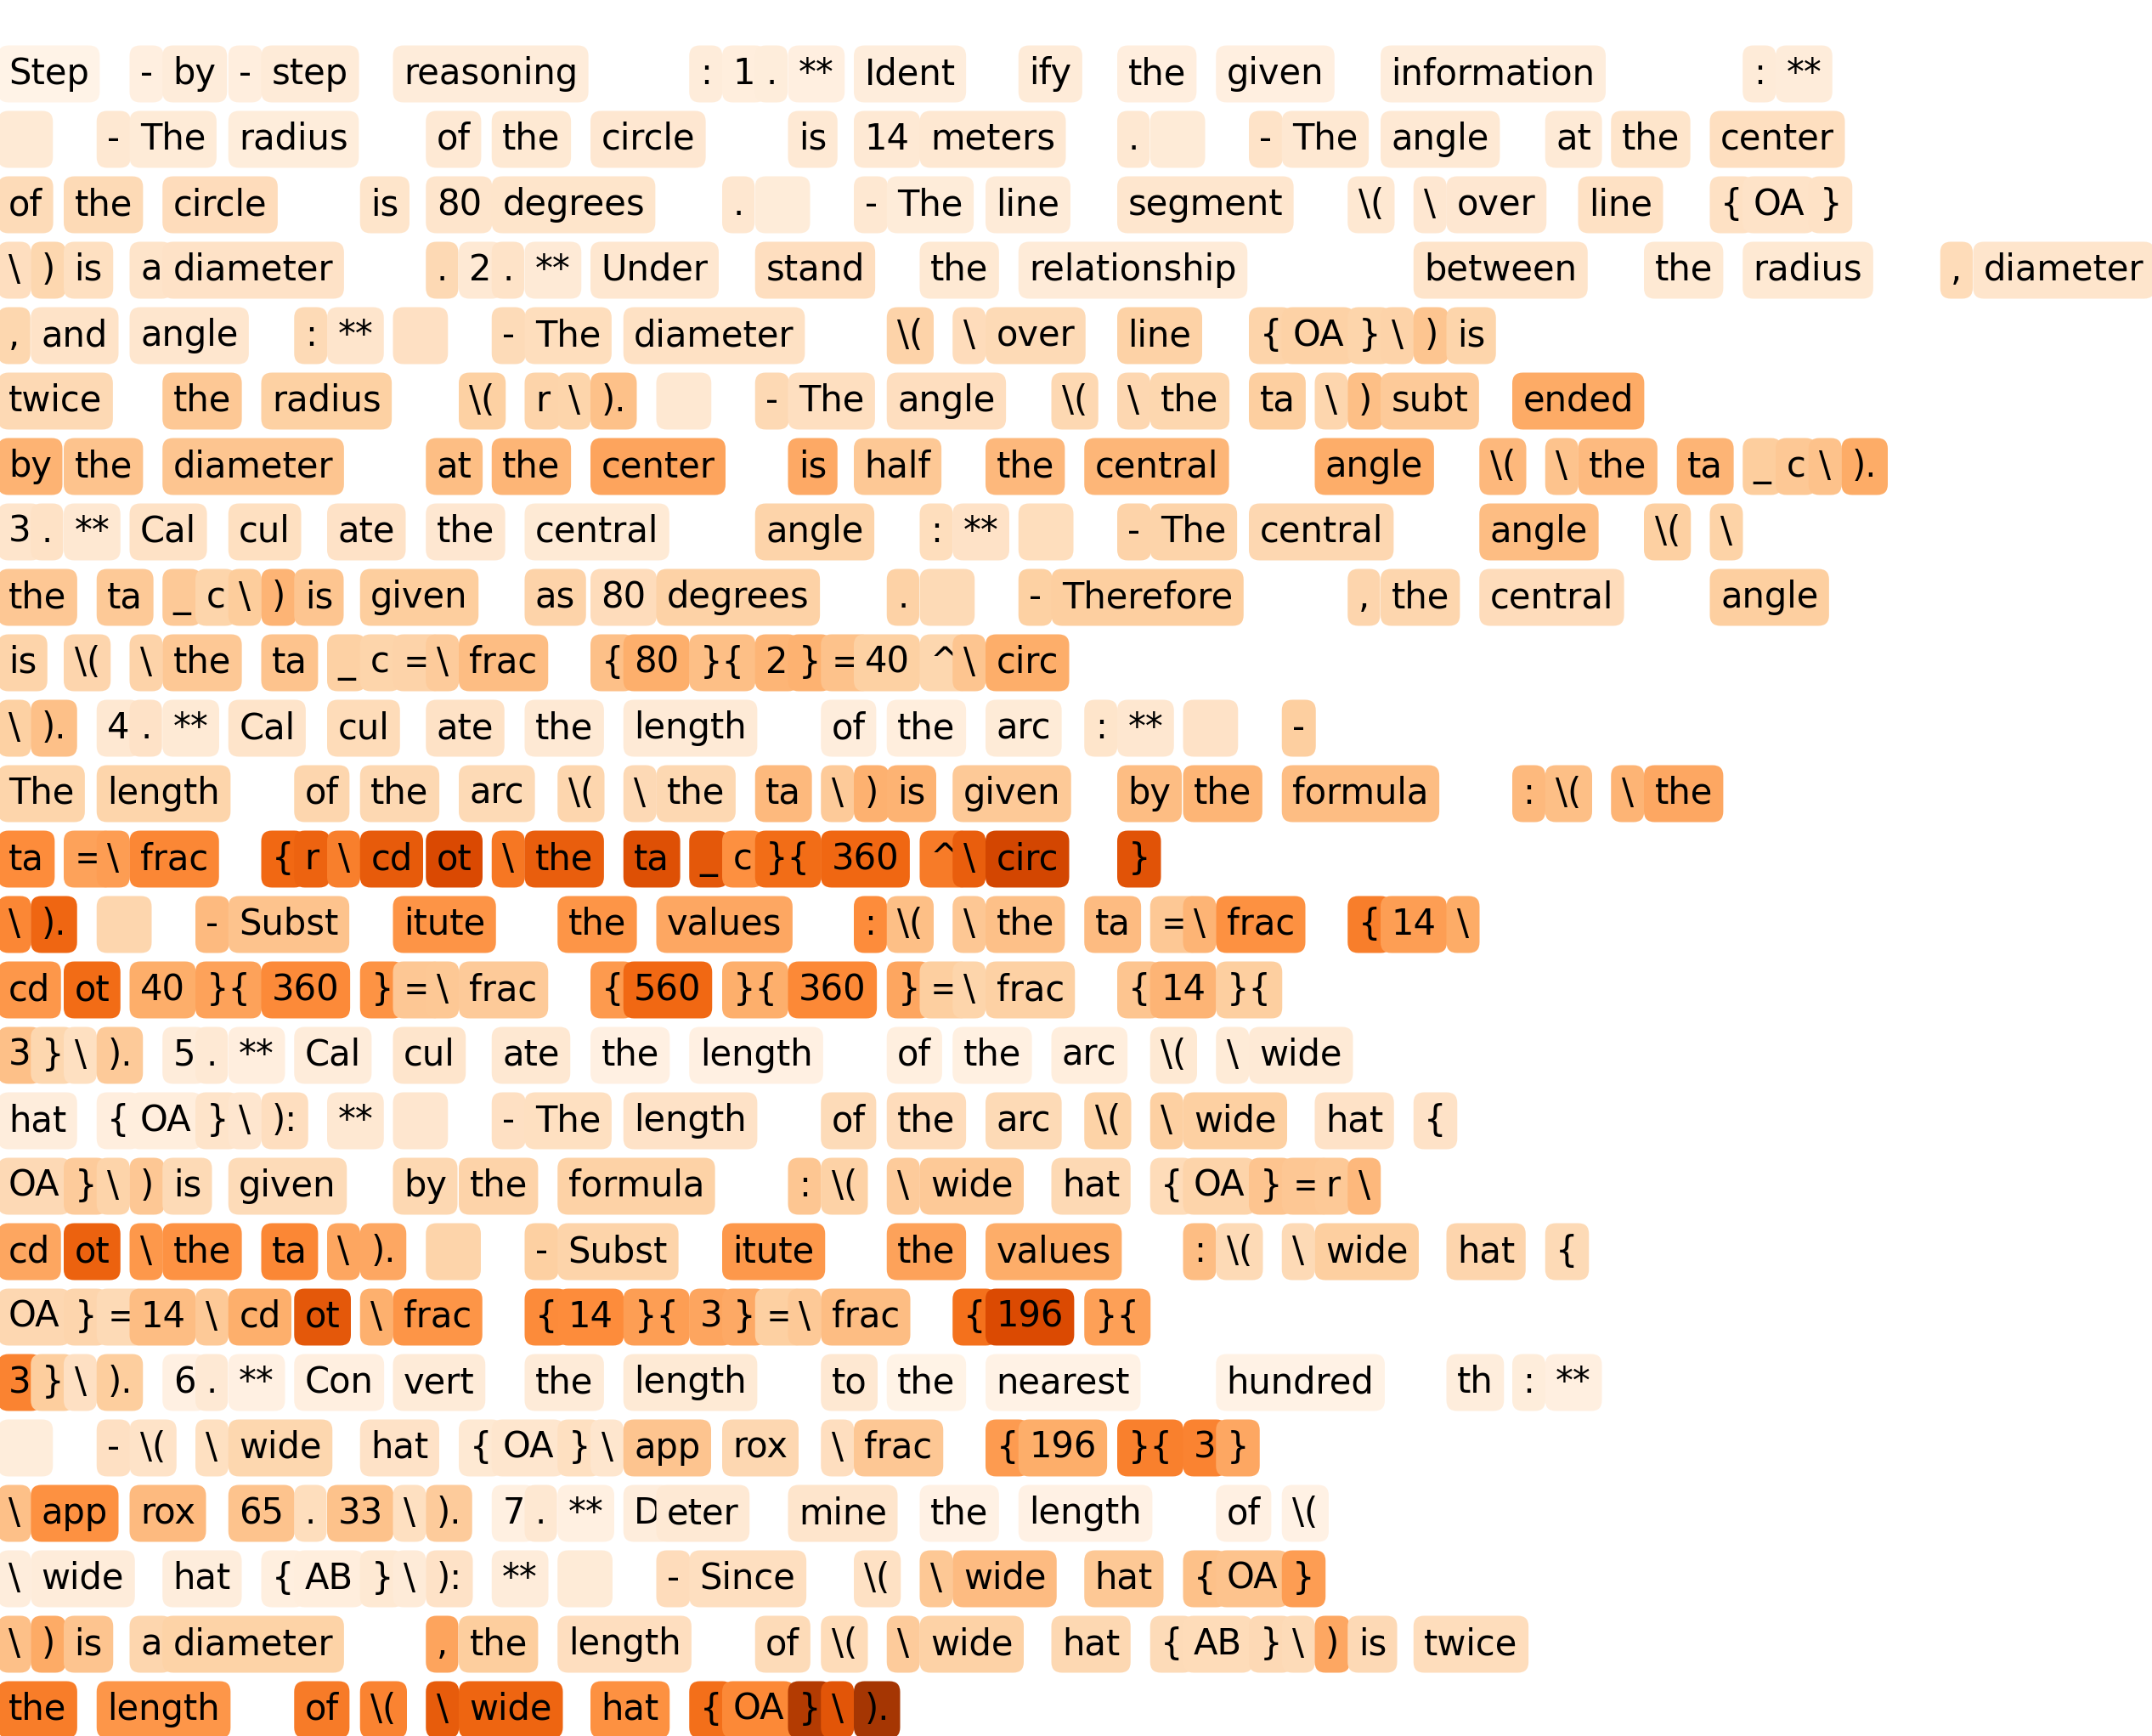

finetuned_peano


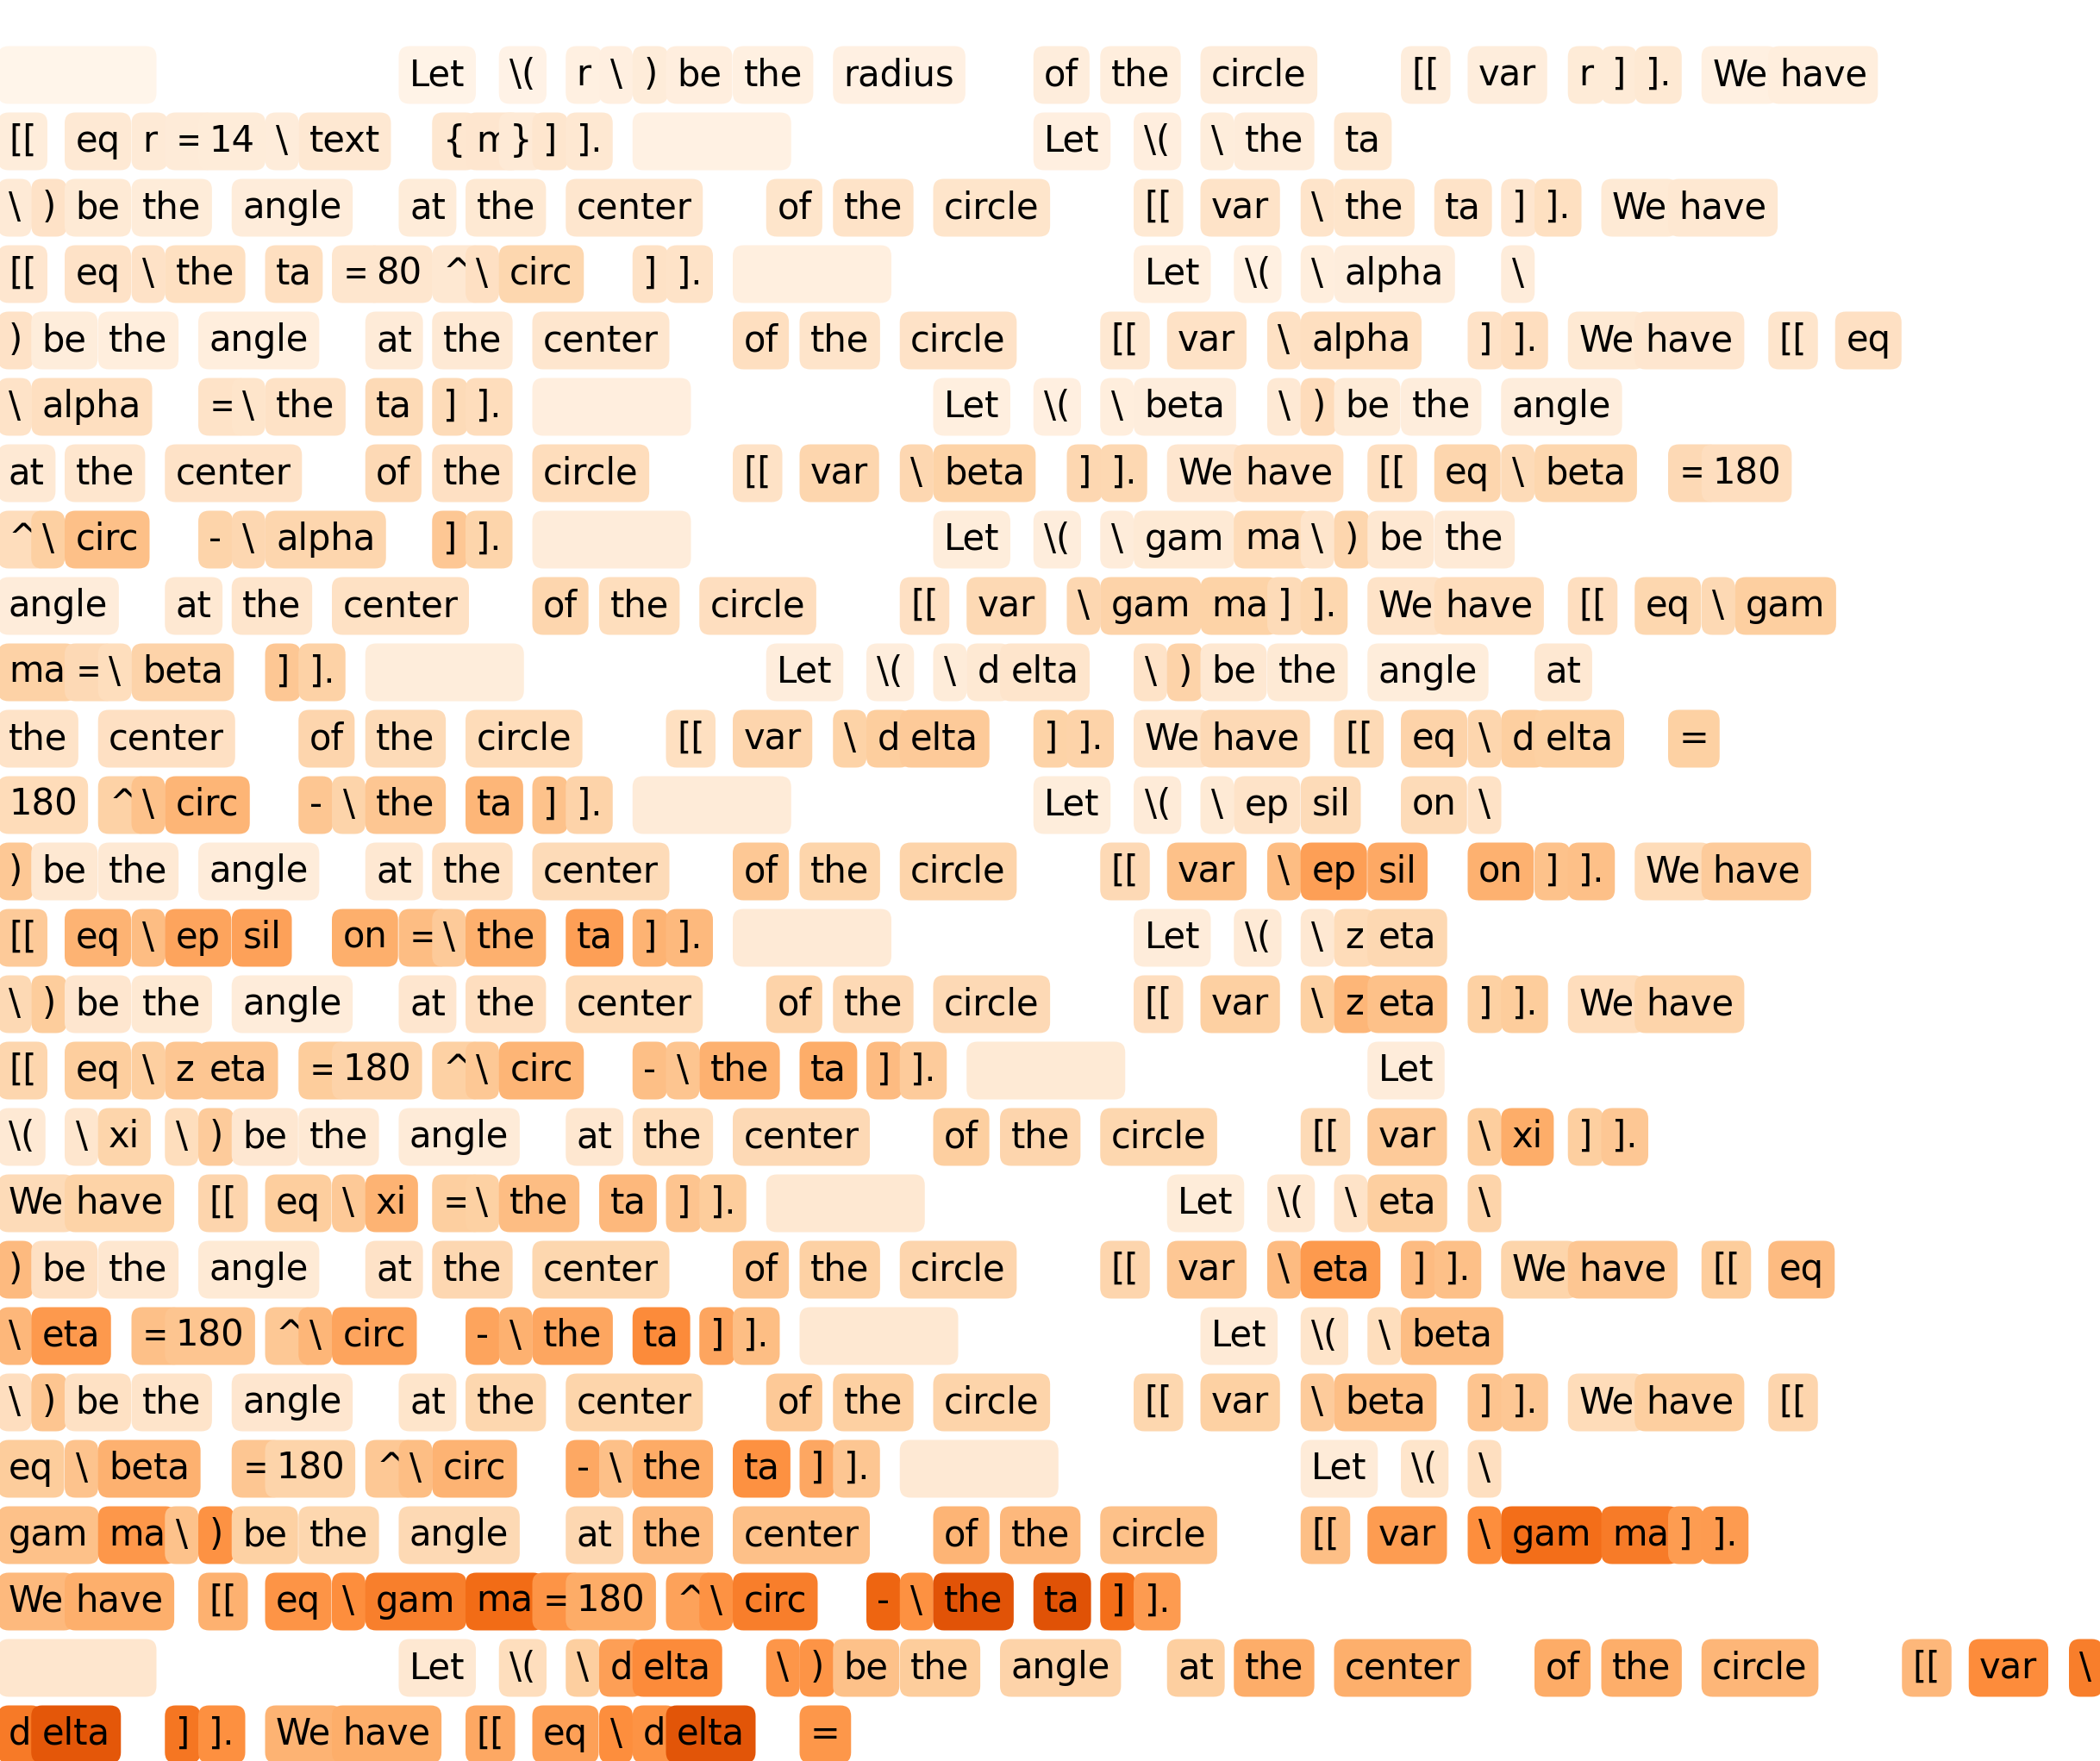

In [31]:
word_map_show = {
  "baseline_direct": 1,
  "baseline_cot": 1,
  "finetuned_cot": 1,
  "finetuned_logic": 1,
  "finetuned_peano": 1,
  "finetuned_multiclass": 0,
}

idx = 21
visualize_word_map(idx, processed_data, word_map_show)